<a href="https://colab.research.google.com/github/rodgpt/MAR_FUTURA/blob/main/Boat%20Detector/Agile/RunModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RunModel

This notebook embeds all WAV files in a folder into a Hoplite DB, loads a previously-trained AGILE linear classifier, and writes an inference CSV.


In [1]:
# @title Imports
#!pip install git+https://github.com/google-research/perch-hoplite.git
#!pip install tensorflow
from etils import epath
import os

from perch_hoplite.agile import audio_loader
from perch_hoplite.agile import classifier
from perch_hoplite.agile import colab_utils
from perch_hoplite.agile import embed
from perch_hoplite.agile import source_info
from perch_hoplite.agile.classifier import LinearClassifier
from perch_hoplite.zoo import model_configs
from pathlib import Path
import shutil # Import shutil for file operations

/Users/rodrigo/Desktop/CODES/.venv311/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
# @title Configuration (COLAB ONLY) - Prefer embeddings cache, otherwise stage audio

import os
import subprocess
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# DRIVE PATHS (source of truth)
# -----------------------------
input_audio_dir_drive = "/content/drive/Shareddrives/MAR FUTURA/Hydrophones/Matanzas/13-11-25/32"
classifier_path_drive = "/content/drive/Shareddrives/MAR FUTURA/Hydrophones/BOAT DETECTOR AGILE/agile_classifier_v2.pt"
output_csv_drive = f"{input_audio_dir_drive}/inference.csv"

# Embeddings cache folder on Drive (you can rename, but keep it stable)
# Recommendation: encode model+sharding in the folder name to avoid accidental mismatch.
emb_cache_drive = f"{input_audio_dir_drive}/_agile_db" ##Check

# -----------------------------
# LOCAL PATHS (fast I/O)
# -----------------------------
run_root = "/content/run_matanzas_32"
input_audio_dir = f"{run_root}/audio"     # LOCAL staged audio (only used if cache missing)
db_path = f"{run_root}/db"                # LOCAL embeddings DB (restored or created)
classifier_path = f"{run_root}/model/agile_classifier_v2.pt"  # LOCAL model copy
output_csv_filepath = f"{run_root}/inference.csv"             # LOCAL output

# Create local directories
Path(db_path).mkdir(parents=True, exist_ok=True)
Path(classifier_path).parent.mkdir(parents=True, exist_ok=True)
Path(output_csv_filepath).parent.mkdir(parents=True, exist_ok=True)

# Ensure Drive cache directory exists
Path(emb_cache_drive).mkdir(parents=True, exist_ok=True)

def drive_cache_nonempty(cache_dir: str) -> bool:
    """True if cache_dir exists and contains at least one file."""
    if not os.path.isdir(cache_dir):
        return False
    for root, _, files in os.walk(cache_dir):
        if files:
            return True
    return False

# Flags used later (main run cell) to decide whether to sync DB back to Drive
embeddings_restored_from_drive = False

# -----------------------------
# STAGE DATA: Prefer embeddings cache -> local
# -----------------------------
if drive_cache_nonempty(emb_cache_drive):
    print("Found embeddings cache on Drive. Restoring embeddings DB to local disk...")
    # Clear local DB folder to avoid mixing old/new artifacts
    subprocess.run(["bash", "-lc", f"rm -rf '{db_path}'/*"], check=True)

    # Restore embeddings cache to local db_path
    subprocess.run([
        "rsync", "-a", "--info=progress2",
        emb_cache_drive.rstrip("/") + "/",
        db_path.rstrip("/") + "/",
    ], check=True)

    # IMPORTANT: do NOT stage audio in this branch
    print("Embeddings restored. Skipping audio staging.")
    staged_audio = False
    embeddings_restored_from_drive = True

else:
    print("No embeddings cache found on Drive. Staging WAV files to local disk so we can embed...")
    Path(input_audio_dir).mkdir(parents=True, exist_ok=True)

    subprocess.run([
        "rsync", "-a", "--info=progress2", "--prune-empty-dirs",
        "--include=*/", "--include=*.wav", "--include=*.WAV",
        "--exclude=*",
        input_audio_dir_drive.rstrip("/") + "/",
        input_audio_dir.rstrip("/") + "/",
    ], check=True)

    staged_audio = True

# Copy classifier weights locally (small optimization; not the main bottleneck)
print("Copying classifier checkpoint locally...")
subprocess.run(["cp", "-f", classifier_path_drive, classifier_path], check=True)

print("----- Paths -----")
print("input_audio_dir_drive:", input_audio_dir_drive)
print("emb_cache_drive:", emb_cache_drive)
print("input_audio_dir (LOCAL):", input_audio_dir)
print("db_path (LOCAL):", db_path)
print("classifier_path (LOCAL):", classifier_path)
print("output_csv_filepath (LOCAL):", output_csv_filepath)
print("output_csv_drive:", output_csv_drive)
print("staged_audio:", staged_audio)
print("embeddings_restored_from_drive:", embeddings_restored_from_drive)


In [2]:
# @title Configuration (LOCAL ONLY)

# Run this cell only if you're running locally.

# -----------------------------
# PATHS (Local)
# -----------------------------

# Example (external drive / Drive File Stream / etc.)
# IMPORTANT: If this points to Google Drive / cloud-synced storage, local runs may be slow
# because files are fetched on-demand. Enable LOCAL_STAGING below to copy WAVs to your
# local SSD before embedding.
input_audio_dir = "/Volumes/Untitled"

db_path =         "/Volumes/Untitled/_agile_db"
output_csv_filepath = "/Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/BOAT DETECTOR AGILE/my_outputTRY.csv"

# Trained classifier path
classifier_path = "agile_classifier_v2.pt"

# -----------------------------
# OPTIONAL: LOCAL STAGING (fast I/O) - AUDIO ONLY
# -----------------------------

# If True, copy WAVs (and optionally classifier) to a true local SSD folder, then repoint
# input_audio_dir to those staged paths.
# IMPORTANT: embeddings DB stays in your ORIGINAL db_path (so you keep embeddings).
ENABLE_LOCAL_STAGING = False

# If True, delete the staged local folder at the end of the main run cell.
CLEANUP_LOCAL_STAGING_ON_FINISH = True

# These globals are used by the main run cell for cleanup.
_LOCAL_STAGING_ENABLED = False
_LOCAL_STAGING_RUN_ROOT = None

if ENABLE_LOCAL_STAGING:
  import subprocess
  from pathlib import Path

  input_audio_dir_src = input_audio_dir
  db_path_src = db_path
  output_csv_filepath_src = output_csv_filepath
  classifier_path_src = classifier_path

  # Choose a fast local destination.
  # You can change this to /tmp/... if you prefer.
  run_root = str(Path.home() / "Library" / "Caches" / "agile_runmodel")

  staged_audio_dir = f"{run_root}/audio"
  staged_model_path = f"{run_root}/model/agile_classifier_v2.pt"

  Path(staged_audio_dir).mkdir(parents=True, exist_ok=True)
  Path(staged_model_path).parent.mkdir(parents=True, exist_ok=True)

  print("Staging WAVs to local SSD...")
  subprocess.run(
      [
          "rsync",
          "-a",
          "--info=progress2",
          "--prune-empty-dirs",
          "--include=*/",
          "--include=*.wav",
          "--include=*.WAV",
          "--exclude=*",
          str(input_audio_dir_src).rstrip("/") + "/",
          str(staged_audio_dir).rstrip("/") + "/",
      ],
      check=True,
  )

  # Optional: copy classifier locally (small optimization)
  print("Copying classifier locally...")
  subprocess.run(["cp", "-f", str(classifier_path_src), str(staged_model_path)], check=True)

  # Repoint ONLY what benefits from local staging
  input_audio_dir = staged_audio_dir
  classifier_path = staged_model_path

  # Keep embeddings + outputs in the original locations
  db_path = db_path_src
  output_csv_filepath = output_csv_filepath_src

  _LOCAL_STAGING_ENABLED = True
  _LOCAL_STAGING_RUN_ROOT = run_root

  print("----- Local staging enabled (audio only) -----")
  print("input_audio_dir_src:", input_audio_dir_src)
  print("input_audio_dir (STAGED):", input_audio_dir)
  print("db_path (UNCHANGED):", db_path)
  print("classifier_path (LOCAL):", classifier_path)
  print("output_csv_filepath (UNCHANGED):", output_csv_filepath)

# NOTE: After running either the Colab cell or the Local cell, always run the Common configuration cell below.


In [3]:
# @title Configuration (COMMON - ALWAYS RUN)

# Run this cell after you run either the Colab-only config cell OR the Local-only config cell.

# -----------------------------
# USER SETTINGS
# -----------------------------

dataset_name = 'RunDataset'
dataset_fileglob = '*.[wW][aA][vV]'

# Embedding model choice MUST match how you embedded when you trained the classifier.
model_choice = 'perch_8'

# Optional sharding (keep consistent with training if possible).
use_file_sharding = True
shard_length_in_seconds = 5

# Performance knobs
# - audio_worker_threads: parallel audio loading/processing
# - embed_batch_size: how many sources are queued per dispatch
# If you overload your machine, lower these.
audio_worker_threads = 8
embed_batch_size = 32

# Inference threshold. Higher => fewer detections.
logit_threshold = 2
labels = None

# File-level rule: require at least N consecutive windows above threshold
min_consecutive_segments = 2

# -----------------------------
# VALIDATE REQUIRED PATHS
# -----------------------------

_required = ['input_audio_dir', 'db_path', 'output_csv_filepath', 'classifier_path']
_missing = [k for k in _required if k not in globals() or not globals()[k]]
if _missing:
  raise RuntimeError(
      'Missing required path variables from the Colab-only or Local-only configuration cell: '
      + ', '.join(_missing)
  )

# Create directories (safe even if they already exist)
Path(output_csv_filepath).parent.mkdir(parents=True, exist_ok=True)
Path(db_path).mkdir(parents=True, exist_ok=True)

# -----------------------------
# CREATE CONFIGS
# -----------------------------

audio_glob = source_info.AudioSourceConfig(
    dataset_name=dataset_name,
    base_path=input_audio_dir,
    file_glob=dataset_fileglob,
    min_audio_len_s=1.0,
    target_sample_rate_hz=-2,
    shard_len_s=float(shard_length_in_seconds) if use_file_sharding else None,
)

configs = colab_utils.load_configs(
    source_info.AudioSources((audio_glob,)),
    db_path,
    model_config_key=model_choice,
    db_key='sqlite_usearch',
)

# Correcting the model handle for surfperch
if model_choice == 'surfperch':
  configs.model_config.model_config.tfhub_path = 'google/surfperch/1'

print('input_audio_dir:', input_audio_dir)
print('db_path:', configs.db_config.db_config.db_path)
print('classifier_path:', classifier_path)
print('output_csv_filepath:', output_csv_filepath)
print('audio_worker_threads:', audio_worker_threads)
print('embed_batch_size:', embed_batch_size)
print('logit_threshold:', logit_threshold)
print('min_consecutive_segments:', min_consecutive_segments)

if 'output_csv_drive' in globals() and output_csv_drive:
  print('output_csv_drive:', output_csv_drive)


input_audio_dir: /Volumes/Untitled
db_path: /Volumes/Untitled/_agile_db
classifier_path: agile_classifier_v2.pt
output_csv_filepath: /Users/Rodrigo/Library/CloudStorage/GoogleDrive-royanedel@marfutura.org/Unidades compartidas/MAR FUTURA/Hydrophones/BOAT DETECTOR AGILE/my_outputTRY.csv
audio_worker_threads: 8
embed_batch_size: 32
logit_threshold: 2
min_consecutive_segments: 2


In [ ]:
#@title Embed folder, load classifier, and run inference

import subprocess
from pathlib import Path

# Sanity checks: make sure input_audio_dir exists and contains WAVs.
# This prevents a silent 0it embed run when the folder is empty / not mounted / fileglob mismatch.

audio_root = Path(str(input_audio_dir))
print('input_audio_dir exists:', audio_root.exists(), 'is_dir:', audio_root.is_dir())

if not audio_root.exists() or not audio_root.is_dir():
    raise RuntimeError(f"input_audio_dir is not a readable directory: {input_audio_dir}")

try:
    wavs_lower = list(audio_root.rglob('*.wav'))
    wavs_upper = list(audio_root.rglob('*.WAV'))
    _wav_count = len(wavs_lower) + len(wavs_upper)
    _wav_examples = [str(p) for p in (wavs_lower[:3] + wavs_upper[:3])]
except Exception as e:
    raise RuntimeError(f"Failed while scanning for WAVs under input_audio_dir={input_audio_dir}: {e}")

print('WAV files found under input_audio_dir (recursive):', _wav_count)
if _wav_examples:
    print('WAV examples:', _wav_examples[:5])

# NOTE: perch-hoplite file_glob is applied relative to base_path. If your WAVs are in nested
# subfolders and you see 0 embeddings, you may need dataset_fileglob like '**/*.[wW][aA][vV]'.
if _wav_count == 0:
    raise RuntimeError(
        f"No WAV files found under input_audio_dir={input_audio_dir}. "
        "Check the path/mount, or update dataset_fileglob (e.g. '**/*.[wW][aA][vV]') if files are in subfolders."
    )

# 1) Connect/create DB (per configs from prior cell)
db = configs.db_config.load_db()
print('Initialized DB located at', configs.db_config.db_config.db_path)

# 2) Embed all files in the folder (skip if DB already non-empty)
print(f'Embedding dataset: {audio_glob.dataset_name}')
worker = embed.EmbedWorker(
    audio_sources=configs.audio_sources_config,
    db=db,
    model_config=configs.model_config,
    audio_worker_threads=int(audio_worker_threads),
)

existing = db.count_embeddings()
print('Existing embeddings in DB:', existing)

did_embed = False

if existing == 0:
    worker.process_all(
        target_dataset_name=audio_glob.dataset_name,
        batch_size=int(embed_batch_size),
    )
    did_embed = True
    print('Embedding complete, total embeddings:', db.count_embeddings())
else:
    print('Skipping embedding because DB is non-empty. Delete the db_path folder to force re-embed.')

# 2a) If local DB staging is enabled, sync the staged DB back to the source RIGHT AFTER embedding.
# This way if the notebook stops before classification finishes, you still keep the embeddings.
_local_db_synced_back_early = False
if (
    did_embed
    and '_LOCAL_DB_STAGING_ENABLED' in globals()
    and _LOCAL_DB_STAGING_ENABLED
    and 'SYNC_DB_BACK_TO_SOURCE_ON_FINISH' in globals()
    and SYNC_DB_BACK_TO_SOURCE_ON_FINISH
    and '_LOCAL_DB_SRC_PATH' in globals()
    and _LOCAL_DB_SRC_PATH
):
    try:
        Path(_LOCAL_DB_SRC_PATH).mkdir(parents=True, exist_ok=True)
        print('Syncing staged DB back to source db_path (early):', _LOCAL_DB_SRC_PATH)
        subprocess.run(
            [
                'rsync',
                '-a',
                '--progress',
                str(db_path).rstrip('/') + '/',
                str(_LOCAL_DB_SRC_PATH).rstrip('/') + '/',
            ],
            check=True,
        )
        _local_db_synced_back_early = True
        print('Done syncing DB back to source (early).')
    except Exception as e:
        print('WARN: early DB sync-back failed:', e)

# 2b) If running in Colab, persist the local DB back to Drive cache
# (Otherwise, /content is ephemeral and you will lose embeddings on runtime reset.)
if did_embed and 'emb_cache_drive' in globals() and emb_cache_drive:
    print('Syncing embeddings DB back to Drive cache:', emb_cache_drive)
    Path(emb_cache_drive).mkdir(parents=True, exist_ok=True)
    subprocess.run(
        [
            'rsync',
            '-a',
            '--progress',
            str(db_path).rstrip('/') + '/',
            str(emb_cache_drive).rstrip('/') + '/',
        ],
        check=True,
    )
    print('Done syncing embeddings cache to Drive.')

# 3) Load embedding model (needed for audio loader in some workflows; kept for parity)
db_model_config = db.get_metadata('model_config')
embed_config = db.get_metadata('audio_sources')
model_class = model_configs.get_model_class(db_model_config.model_key)
embedding_model = model_class.from_config(db_model_config.model_config)
audio_sources = source_info.AudioSources.from_config_dict(embed_config)
window_size_s = getattr(embedding_model, 'window_size_s', 5.0)
_ = audio_loader.make_filepath_loader(
    audio_sources=audio_sources,
    window_size_s=window_size_s,
    sample_rate_hz=embedding_model.sample_rate,
)

# 4) Load trained classifier and write inference CSV (window-level)
linear_classifier = LinearClassifier.load(classifier_path)
classifier.write_inference_csv(
    linear_classifier,
    db,
    output_csv_filepath,
    logit_threshold,
    labels=labels,
)
print('Done. Wrote window-level CSV:', output_csv_filepath)

# 5) Post-process: per-file "boat" decision requires consecutive windows
# This produces a file-level CSV next to the window-level CSV.
import pandas as pd

score_col = None
file_level_csv = str(Path(output_csv_filepath).with_name(Path(output_csv_filepath).stem + '_filelevel.csv'))

try:
    df = pd.read_csv(output_csv_filepath)
except FileNotFoundError:
    raise

if df.empty:
    print('Inference CSV was empty; skipping file-level post-processing.')
else:
    # Be tolerant to either 'logit' or 'logits'
    for c in ('logit', 'logits', 'score', 'prob', 'probability'):
        if c in df.columns:
            score_col = c
            break

    if score_col is None:
        raise RuntimeError('Could not find a score column in inference CSV. Expected one of: logit, logits, score, prob, probability')

    # Focus label if present
    if 'label' in df.columns:
        df = df[df['label'].astype(str) == 'boat']

    if df.empty:
        print('No rows for label=boat in inference CSV; writing empty file-level CSV.')
        pd.DataFrame(columns=['filename', 'best_score', 'segments_over_threshold', 'longest_consecutive', 'is_boat']).to_csv(file_level_csv, index=False)
    else:
        df['window_start'] = pd.to_numeric(df.get('window_start'), errors='coerce')
        df[score_col] = pd.to_numeric(df[score_col], errors='coerce')

        df = df.dropna(subset=['filename', 'window_start', score_col]).copy()

        def longest_run(starts, step):
            starts = sorted(set(starts))
            if not starts:
                return 0
            eps = max(1e-6, abs(step) * 1e-6)
            best = 1
            cur = 1
            for i in range(1, len(starts)):
                if abs((starts[i] - starts[i-1]) - step) <= eps:
                    cur += 1
                else:
                    best = max(best, cur)
                    cur = 1
            return max(best, cur)

        rows = []
        step = float(shard_length_in_seconds)
        thr = float(logit_threshold)
        min_cons = int(min_consecutive_segments)

        for fname, g in df.groupby('filename'):
            over = g[g[score_col] >= thr]
            starts_over = over['window_start'].dropna().tolist()
            lr = longest_run(starts_over, step)
            best = float(g[score_col].max()) if not g.empty else None
            cnt = int(len(starts_over))
            is_boat = lr >= min_cons
            rows.append({
                'filename': fname,
                'best_score': best,
                'segments_over_threshold': cnt,
                'longest_consecutive': lr,
                'is_boat': bool(is_boat),
            })

        out_df = pd.DataFrame(rows).sort_values(['is_boat', 'best_score'], ascending=[False, False])
        out_df.to_csv(file_level_csv, index=False)
        print('Wrote file-level CSV:', file_level_csv)

# 6) Optionally copy output CSV back to Drive (only if configured)
if 'output_csv_drive' in globals() and output_csv_drive:
    print('Copying inference CSV back to Drive...')
    subprocess.run(['cp', '-f', output_csv_filepath, output_csv_drive], check=True)
    print('Done. Wrote:', output_csv_drive)

# 7) If local DB staging is enabled, optionally sync the staged DB back to the original source folder.
# If the early sync already happened, this is redundant but safe.
_local_db_synced_back = _local_db_synced_back_early
if (
    (not _local_db_synced_back)
    and '_LOCAL_DB_STAGING_ENABLED' in globals()
    and _LOCAL_DB_STAGING_ENABLED
    and 'SYNC_DB_BACK_TO_SOURCE_ON_FINISH' in globals()
    and SYNC_DB_BACK_TO_SOURCE_ON_FINISH
    and '_LOCAL_DB_SRC_PATH' in globals()
    and _LOCAL_DB_SRC_PATH
):
    try:
        Path(_LOCAL_DB_SRC_PATH).mkdir(parents=True, exist_ok=True)
        print('Syncing staged DB back to source db_path:', _LOCAL_DB_SRC_PATH)
        subprocess.run(
            [
                'rsync',
                '-a',
                '--progress',
                str(db_path).rstrip('/') + '/',
                str(_LOCAL_DB_SRC_PATH).rstrip('/') + '/',
            ],
            check=True,
        )
        _local_db_synced_back = True
        print('Done syncing DB back to source.')
    except Exception as e:
        print('WARN: failed to sync DB back to source:', e)

# 8) Optional cleanup of local staging folder (audio/model/db)
# If DB staging was enabled but sync-back failed, skip cleanup so you don't lose the staged DB.
_skip_cleanup = (
    '_LOCAL_DB_STAGING_ENABLED' in globals()
    and _LOCAL_DB_STAGING_ENABLED
    and 'SYNC_DB_BACK_TO_SOURCE_ON_FINISH' in globals()
    and SYNC_DB_BACK_TO_SOURCE_ON_FINISH
    and not _local_db_synced_back
)

if _skip_cleanup:
    print('WARN: skipping cleanup because DB sync-back did not succeed. Staged DB preserved at:', db_path)

if (
    not _skip_cleanup
    and 'CLEANUP_LOCAL_STAGING_ON_FINISH' in globals()
    and CLEANUP_LOCAL_STAGING_ON_FINISH
    and '_LOCAL_STAGING_RUN_ROOT' in globals()
    and _LOCAL_STAGING_RUN_ROOT
    and (
        ('_LOCAL_AUDIO_STAGING_ENABLED' in globals() and _LOCAL_AUDIO_STAGING_ENABLED)
        or ('_LOCAL_DB_STAGING_ENABLED' in globals() and _LOCAL_DB_STAGING_ENABLED)
    )
):
    import shutil
    try:
        print('Cleaning up local staged folder:', _LOCAL_STAGING_RUN_ROOT)
        shutil.rmtree(_LOCAL_STAGING_RUN_ROOT, ignore_errors=True)
        print('Cleanup complete.')
    except Exception as e:
        print('WARN: cleanup failed:', e)


input_audio_dir exists: True is_dir: True
WAV files found under input_audio_dir (recursive): 15256
WAV examples: ['/Volumes/Untitled/20251211_112600.WAV', '/Volumes/Untitled/20251211_112800.WAV', '/Volumes/Untitled/20251211_113000.WAV']
Initialized DB located at /Volumes/Untitled/_agile_db
Embedding dataset: RunDataset
Existing embeddings in DB: 0


 11%|█         | 1684/15256 [00:57<07:47, 29.06it/s]

rows: 10
columns: ['idx', 'project', 'filename', 'window_start', 'window_end', 'label', 'logits']


/var/folders/98/p03nljld21n2xrkp6cmfsv6w0000gn/T/ipykernel_7060/843608019.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  detections_per_hour = plot_df['idx'].resample('1H').count()


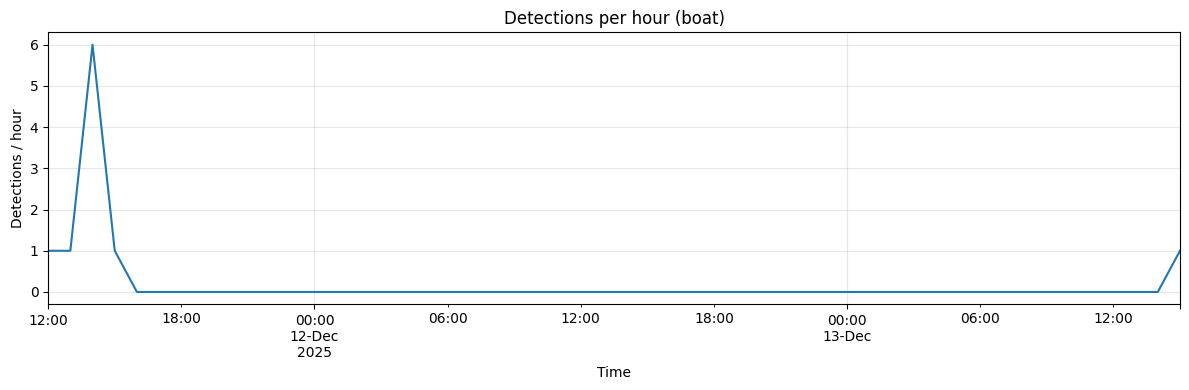

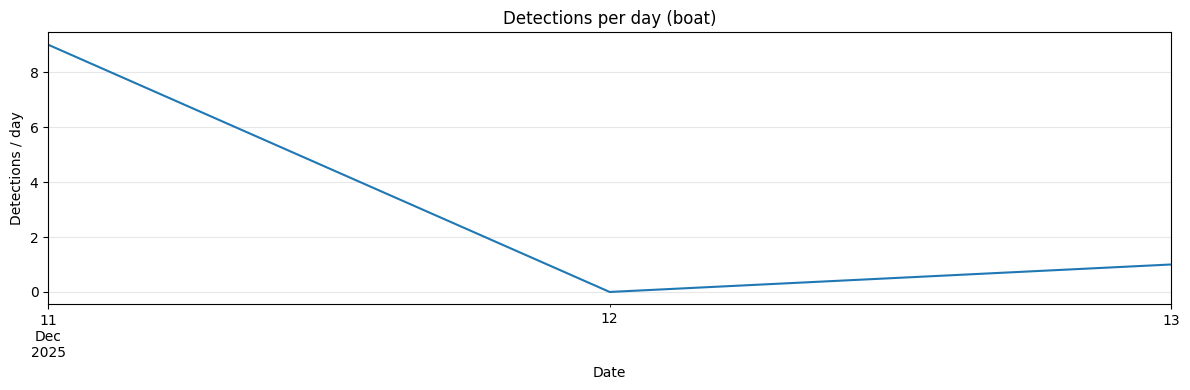

In [12]:
#@title Plot detections over time (detections/hour)

import re
import pandas as pd
import matplotlib.pyplot as plt

csv_path = output_csv_filepath

df = pd.read_csv(csv_path)
print('rows:', len(df))
print('columns:', list(df.columns))

# Optional: focus on one label (e.g. boat). Set to None to include all labels.
focus_label = 'boat'
if focus_label and 'label' in df.columns:
  df = df[df['label'] == focus_label]

# Parse datetime from filename like YYYYMMDD_HHMMSS(.WAV)
# Example: ZAPALLAR_20241122_143550_5sec.wav -> 20241122_143550
_dt_re = re.compile(r'(\d{8})_(\d{6})')

def extract_dt(fname: str):
  m = _dt_re.search(str(fname))
  if not m:
    return pd.NaT
  return pd.to_datetime(m.group(1) + m.group(2), format='%Y%m%d%H%M%S', errors='coerce')

df['file_dt'] = df['filename'].apply(extract_dt)

# If window_start exists, shift timestamp by that many seconds.
if 'window_start' in df.columns:
  df['window_start'] = pd.to_numeric(df['window_start'], errors='coerce')
  df['dt'] = df['file_dt'] + pd.to_timedelta(df['window_start'].fillna(0), unit='s')
else:
  df['dt'] = df['file_dt']

# Drop rows where we can't parse time
plot_df = df.dropna(subset=['dt']).copy()
if plot_df.empty:
  raise RuntimeError('No rows had a parseable datetime in filename. Adjust extract_dt() regex/format.')

plot_df = plot_df.set_index('dt').sort_index()

detections_per_hour = plot_df['idx'].resample('1H').count()

plt.figure(figsize=(12, 4))
detections_per_hour.plot()
plt.title(f'Detections per hour' + (f" ({focus_label})" if focus_label else ''))
plt.xlabel('Time')
plt.ylabel('Detections / hour')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: show daily totals too
show_daily = True

if show_daily:
  daily = plot_df['idx'].resample('1D').count()
  plt.figure(figsize=(12, 4))
  daily.plot()
  plt.title(f'Detections per day' + (f" ({focus_label})" if focus_label else ''))
  plt.xlabel('Date')
  plt.ylabel('Detections / day')
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()
